## Chapter 30 Project: Monthly Armed Robberies in Boston

### Overview
1. Problem Description
2. Test harness
3. Persistence
4. Data Analysis
5. ARIMA Models
6. Model Validation




#### 1. Problem Description

The problem is to predict the number of monthly armed robberies in Boston, USA. The dataset provides the number of monthly armed robberies in Boston from January 1966 to October 1975, or just under 10 years of data. The values are a count and there are 118 observations. The dataset is credited to McCleary and Hay (1980).

#### 2. Test Harness

We must develop a test harness to investigate the data and evaluate candidate models. This involves two steps:
1. Defining a Validation Dataset.
2. Developing a Method for Model Evaluation.

##### (1) Validation Dataset

The dataset is not current. This means that we cannot easily collect updated data to validate the model. Therefore we will pretend that it is October 1974 and withhold the last one year of data from analysis and model selection. This final year of data will be used to validate the final model.

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [16]:
# load the dataset
series = pd.read_csv('data/robberies.csv', index_col=0, parse_dates=True)
series.head()

,Robberies
Month,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43


In [17]:
# split into a training and validation dataset
split_point = len(series) - 12
dataset, validation = series[:split_point], series[split_point:]
print(f'Dataset {len(dataset)}, Validation {len(validation)}')
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 106, Validation 12


##### (2) Model Evaluation

Model evaluation will only be performed on the data in dataset.csv prepared in the previous section. Model evaluation involves two elements:
1. Performance Measure: The observations are a count of robberies. We will evaluate the performance of predictions using the root mean squared error (RMSE).
2. Test Strategy: Candidate models will be evaluated using walk-forward validation.

The walk-forward validation will work as follows:
1. The first 50% of the dataset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model.
3. For each step in the test dataset:
  - (a) A model will be trained.
  - (b) A one-step prediction made and the prediction stored for later evaluation.
  - (c) The actual observation from the test dataset will be added to the training dataset for the next iteration.
4. The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

#### 3. Persistence

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed
test harness and a performance measure by which all more elaborate predictive models can be compared. The baseline prediction for time series forecasting is called the *naive forecast, or persistence*. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

In [18]:
# evaluate a persistence model
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Robberies'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')

>Predicted=98.000, Expected=125.000
>Predicted=125.000, Expected=155.000
>Predicted=155.000, Expected=190.000
>Predicted=190.000, Expected=236.000
>Predicted=236.000, Expected=189.000
>Predicted=189.000, Expected=174.000
>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>P

#### 4. Data Analysis

##### (1) Summary Statistics

In [19]:
# summary statistics of time series
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
series.describe()

,Robberies
count,106.000000
mean,173.103774
std,112.231133
min,29.000000
25%,74.750000
50%,144.500000
75%,271.750000
max,487.000000


The large spread in this series will likely make highly accurate predictions diﬃcult if it is caused by random fluctuation (e.g. not systematic).

##### (2) Line Plot

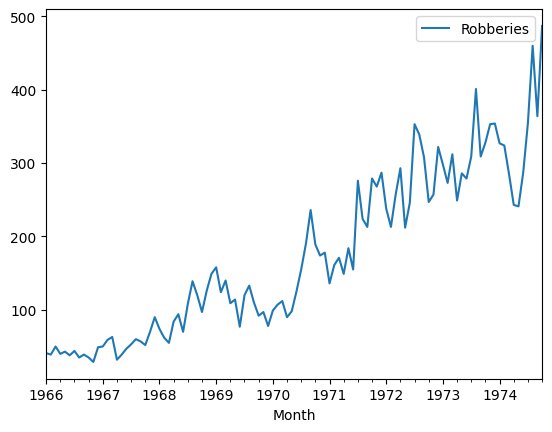

In [20]:
series.plot()
plt.show()

Some observations from the plot include:
- There is an increasing trend of robberies over time.
- There do not appear to be any obvious outliers.
- There are relatively large fluctuations from year to year, up and down.
- The fluctuations at later years appear larger than fluctuations at earlier years.
- The trend means the dataset is almost certainly non-stationary and the apparent change in fluctuation may also contribute.

These simple observations suggest we may see benefit in modeling the trend and removing it from the time series. Alternately, we could use diﬀerencing to make the series stationary for modeling. We may even need two levels of diﬀerencing if there is a growth trend in the
fluctuations in later years.

##### (3) Density Plot

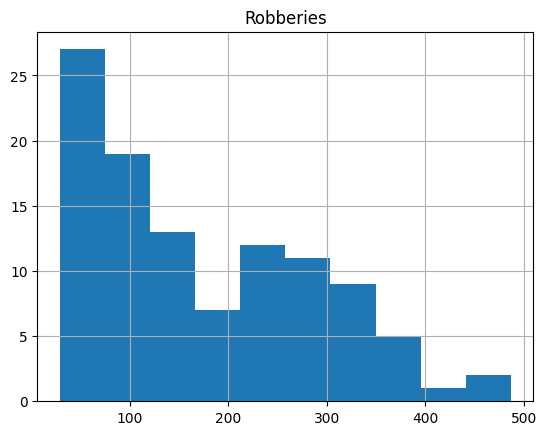

In [21]:
# density plots of time series
series.hist()
plt.show()

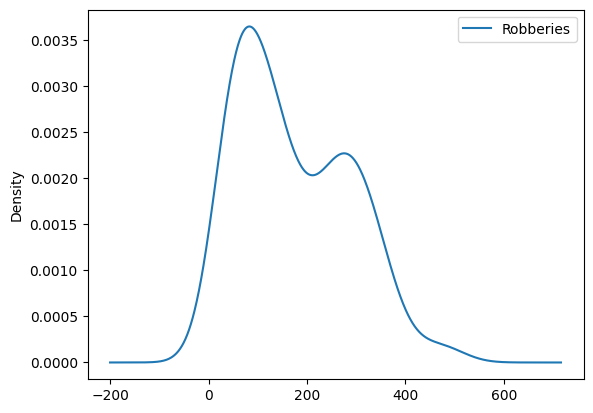

In [22]:
series.plot(kind='kde')
plt.show()

Some observations from the plots include:
- The distribution is not Gaussian.
- The distribution is left shifted and may be exponential or a double Gaussian.

We may see some benefit in exploring some power transforms of the data prior to modeling.

##### (3) Box and Whisker Plots



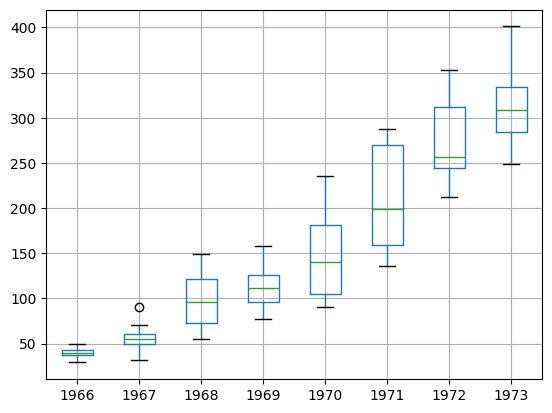

In [23]:
# boxplots of time series
df = pd.read_csv('dataset.csv')
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
groups = df.groupby('Year')
years = pd.DataFrame()
for name, group in groups:
  if name != 1974:
    years[name] = group['Robberies'].values
years.boxplot()
plt.show()

Some observations from reviewing the plot include:
- The median values for each year show a trend that may not be linear.
- The spread, or middle 50% of the data differ but perhaps not consistently over time.
- The earlier years, perhaps first 2, are quite different from the rest of the dataset.

The observations suggest that the year-to-year fluctuations may not be systematic and hard to model. They also suggest that there may be some benefit in clipping the first two years of data from modeling if it is indeed quite diﬀerent. This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from year-to-year and changes in summary stats from year-to-year.

#### 5. ARIMA Models

##### (1) Manually Configured ARIMA

Nonseasonal ARIMA(p,d,q) requires three parameters and is traditionally configured manually.
*Analysis of the time series data assumes that we are working with a stationary time series*. The time series is almost certainly non-stationary. We can make it stationary by first diﬀerencing
the series and using a statistical test to confirm that the result is stationary.

In [24]:
# statistical test for the stationarity of the time series
from statsmodels.tsa.stattools import adfuller

# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i-1]
    diff.append(value)
  return pd.Series(diff)

series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
X = series['Robberies'].values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]

# Check if stationary
result = adfuller(stationary)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
  print(f'\t ({key}, {value:.3f})')

ADF Statistic: -3.980946303861115
p-value: 0.0015136348242122516
Critical Values:
	 (1%, -3.503)
	 (5%, -2.893)
	 (10%, -2.584)


The results show that the test statistic value -3.98 is smaller than the critical value at 1% of -3.503. This suggests that we can reject the null hypothesis with a significance level of less than 1%.
Rejecting the null hypothesis means that the process has no unit root, and in turn that the 1-lag diﬀerenced time series is stationary or does not have time-dependent structure.

This suggests that at least one level of diﬀerencing is required. The d parameter in our ARIMA model should at least be a value of 1. The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can
do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

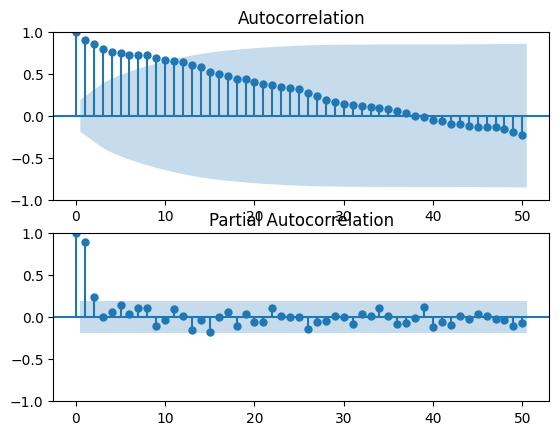

In [25]:
# ACF and PACF plots of time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
plt.figure()
plt.subplot(211)
plot_acf(series, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=50, ax=plt.gca())
plt.show()

Some observations from the plots are:
- The ACF shows a significant lag for 10-11 months.
- The PACF shows a significant lag for perhaps 2 months.

A good starting point for the p and q values are 11 and 2.

This quick analysis suggests an ARIMA(11,1,2) on the raw data may be a good starting point. Experimentation shows that this configuration of ARIMA does not converge and results in errors by the underlying library, as do similarly large AR values. Some experimentation shows
that the model does not appear to be stable, with non-zero AR and MA orders defined at the same time. The model can be simplified to ARIMA(0,1,2).

Below demonstrates the performance of this ARIMA model on the test harness.

In [26]:
# evalute manually configured ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Robberies'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')

>Predicted=99.923, Expected=125.000
>Predicted=116.442, Expected=155.000
>Predicted=139.962, Expected=190.000
>Predicted=176.933, Expected=236.000
>Predicted=232.851, Expected=189.000
>Predicted=184.697, Expected=174.000
>Predicted=180.705, Expected=178.000
>Predicted=179.873, Expected=136.000
>Predicted=141.098, Expected=161.000
>Predicted=166.173, Expected=171.000
>Predicted=167.005, Expected=149.000
>Predicted=150.656, Expected=184.000
>Predicted=182.314, Expected=155.000
>Predicted=154.213, Expected=276.000
>Predicted=245.214, Expected=224.000
>Predicted=225.902, Expected=213.000
>Predicted=216.867, Expected=279.000
>Predicted=258.698, Expected=268.000
>Predicted=263.377, Expected=287.000
>Predicted=279.945, Expected=238.000
>Predicted=251.485, Expected=213.000
>Predicted=226.574, Expected=257.000
>Predicted=249.690, Expected=293.000
>Predicted=277.211, Expected=212.000
>Predicted=230.020, Expected=246.000
>Predicted=245.786, Expected=353.000
>Predicted=317.992, Expected=339.000
>P

##### (2) Grid Search ARIMA Hyperparameters

In [27]:
# grid search ARIMA parameters for time series
import warnings
warnings.filterwarnings("ignore")

# evalute an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  X = X.astype(float)
  train_size = int(len(X) * 0.50)
  train, test = X[:train_size], X[train_size:]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = np.sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype(float)
  best_score, best_cfg = float('inf'), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, d, q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print(f'ARIMA {order} RMSE={rmse:.3f}')
        except:
          continue
  print(f'Best ARIMA {best_cfg} RMSE={best_score:.3f}')

# load dataset
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(series['Robberies'].values, p_values, d_values, q_values)

ARIMA (0, 0, 0) RMSE=109.630
ARIMA (0, 0, 1) RMSE=81.385
ARIMA (0, 0, 2) RMSE=69.050
ARIMA (0, 1, 0) RMSE=71.739
ARIMA (0, 1, 1) RMSE=66.986
ARIMA (0, 1, 2) RMSE=66.036
ARIMA (0, 2, 0) RMSE=117.397
ARIMA (0, 2, 1) RMSE=71.823
ARIMA (0, 2, 2) RMSE=66.776
ARIMA (1, 0, 0) RMSE=65.205
ARIMA (1, 0, 1) RMSE=64.140
ARIMA (1, 0, 2) RMSE=64.212
ARIMA (1, 1, 0) RMSE=67.616
ARIMA (1, 1, 1) RMSE=64.987
ARIMA (1, 1, 2) RMSE=63.959
ARIMA (1, 2, 0) RMSE=89.801
ARIMA (1, 2, 1) RMSE=67.623
ARIMA (1, 2, 2) RMSE=65.377
ARIMA (2, 0, 0) RMSE=63.442
ARIMA (2, 0, 1) RMSE=63.290
ARIMA (2, 0, 2) RMSE=63.339
ARIMA (2, 1, 0) RMSE=67.411
ARIMA (2, 1, 1) RMSE=63.546
ARIMA (2, 1, 2) RMSE=63.401
ARIMA (2, 2, 0) RMSE=84.798
ARIMA (2, 2, 1) RMSE=67.422
ARIMA (2, 2, 2) RMSE=67.093
Best ARIMA (2, 0, 1) RMSE=63.290


##### (3) Review Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean. We can check this by plotting the residuals with a histogram and density plots.

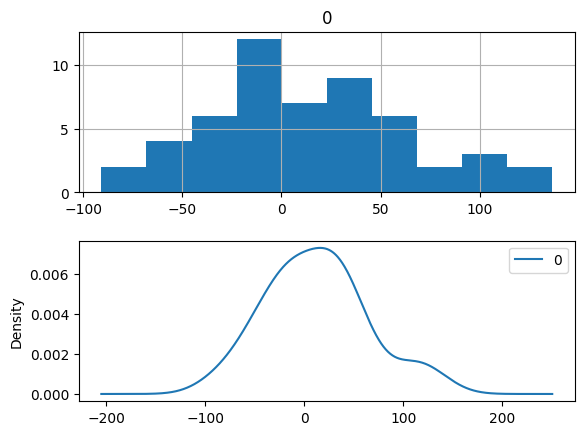

In [29]:
# plto residual errors for ARIMA model
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Robberies'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(2, 0, 1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The graphs suggest a Gaussian-like distribution with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case that perhaps a power-based transform of the raw data before modeling might be useful.

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

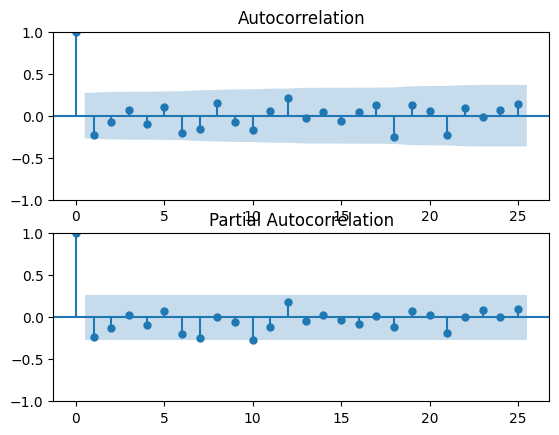

In [30]:
# ACF and PACF plots of forecast residual errors
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.show()

##### (4) Box-Cox Transformed Dataset

The **Box-Cox transform** is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data.

Lambda: 0.26006027610165455


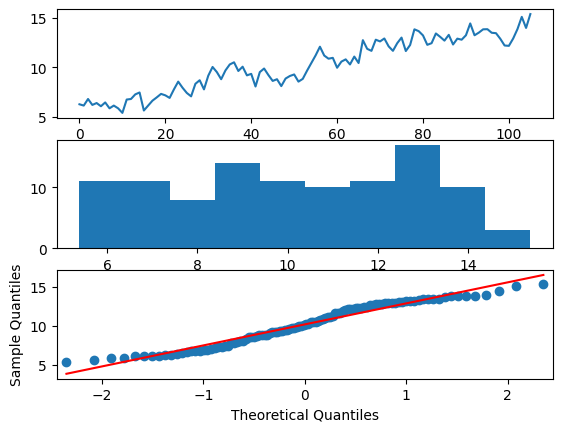

In [31]:
# plots of box-cox transformed dataset
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
X = series['Robberies'].astype(float).values
transformed, lam = boxcox(X)
print(f'Lambda: {lam}')

plt.figure()
# line plot
plt.subplot(311)
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.show()

Some observations from these plots are as follows:
- The larget fluctuations have been removed from the line plot of the time series.
- The histogram shows a flatter or more uniform (well behaved) distribution of values.
- The Q-Q plot is reasonable, but still not a perfect fit for a Gaussin distribution.

Undoubtedly, the Box-Cox transform has done something to the time series and may be useful. Before proceeding to test the ARIMA model with the transformed data, we must have a way to reverse the transform in order to convert predictions made with a model trained on
the transformed data back into the original scale. The boxcox() function used in the example finds an ideal lambda value by optimizing a cost function. The lambda is used in the following function to transform the data:

for a variable $y>0$:
- if $\lambda=0, y(\lambda)=ln(y).$
- if $\lambda\neq 0, y(\lambda)=\frac{y^\lambda - 1}{\lambda}.$

This transform function can be reversed directly as follows:
- if $\lambda=0, y=exp(transform)$.
- if $\lambda \neq 0, y = exp(log(\lambda \times transform + 1)/\lambda)$.


In [32]:
# invert Box-Cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return np.exp(value)
  return np.exp(np.log(lam * value + 1) / lam)

By convention, lambda values are evaluated between -5 and 5.
A check is added for a lambda value less than -5, and if this the case, a lambda value of 1 is assumed and the raw history is used to fit the model. A lambda value of 1 is the same as no-transform and therefore the inverse transform has no eﬀect.

In [34]:
# evaluate ARIMA models with box-cox transformed time series
from scipy.stats import boxcox

# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Robberies'].astype(float).values
train_size = int(len(X) * 0.50)
train, test = X[:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(2, 0, 1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print(f'>Prediction={yhat:.3f}, Expected={obs:.3f}')
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')

>Prediction=96.071, Expected=125.000
>Prediction=112.177, Expected=155.000
>Prediction=139.004, Expected=190.000
>Prediction=184.563, Expected=236.000
>Prediction=208.358, Expected=189.000
>Prediction=186.378, Expected=174.000
>Prediction=155.652, Expected=178.000
>Prediction=176.521, Expected=136.000
>Prediction=124.792, Expected=161.000
>Prediction=156.721, Expected=171.000
>Prediction=156.876, Expected=149.000
>Prediction=142.911, Expected=184.000
>Prediction=173.201, Expected=155.000
>Prediction=154.519, Expected=276.000
>Prediction=232.093, Expected=224.000
>Prediction=211.558, Expected=213.000
>Prediction=207.045, Expected=279.000
>Prediction=251.228, Expected=268.000
>Prediction=252.917, Expected=287.000
>Prediction=269.754, Expected=238.000
>Prediction=240.628, Expected=213.000
>Prediction=219.524, Expected=257.000
>Prediction=245.684, Expected=293.000
>Prediction=272.409, Expected=212.000
>Prediction=222.649, Expected=246.000
>Prediction=240.106, Expected=353.000
>Prediction=3

We will use this model with the Box-Cox transform as the final model.

#### 6. Model Validation

After models have been developed and a final model selected, it must be validated and finalized.
Validation is an optional part of the process, but one that provides a last check to ensure we have not fooled or lied to ourselves.

##### (1) Finalize Model: Train and save the final model

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a transformed version of the entire dataset. Once fit, the model can be saved to file for later use.
Because a Box-Cox transform is also performed on the data, we need to know the chosen lambda so that any predictions from the model can be converted back to the original, untransformed scale.

In [35]:
# finalize model and save file
# load data
series = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
# prepare data
X = series['Robberies'].astype(float).values
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(2, 0, 1))
model_fit = model.fit()
# save model
model_fit.save('model.pkl')
np.save('model_lambda.npy', [lam])

##### (2) Make Prediction: Load the finalized model and make a prediction

In [46]:
# load the finalized model and make a prediction
model_fit_loaded = model_fit.load('model.pkl')
lam_loaded = np.load('model_lambda.npy')
yhat = model_fit_loaded.forecast()[0]
yhat = boxcox_inverse(yhat, lam_loaded)[0]
print(f'Predicted: {yhat:.3f}')

Predicted: 439.778


Running the example prints the prediction of about 439.78. If we peek inside validation.csv, we can see that the value on the first row for the next time period is 452.

##### (3) Validate Model: Load and validate the final model

In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model.
We can load this validation.csv file now and use it see how well our model really is on unseen data.

There are two ways we might proceed:
- Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
- Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice, as it would achieve the best performance.

As with model evaluation in previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the
observations as an update to the history.

>Predicted=439.778, Expected=452.000
>Predicted=430.906, Expected=391.000
>Predicted=393.557, Expected=500.000
>Predicted=465.970, Expected=451.000
>Predicted=443.767, Expected=375.000
>Predicted=391.634, Expected=372.000
>Predicted=382.414, Expected=302.000
>Predicted=326.454, Expected=316.000
>Predicted=326.796, Expected=398.000
>Predicted=380.370, Expected=394.000
>Predicted=382.309, Expected=431.000
>Predicted=410.491, Expected=431.000
RMSE: 52.467


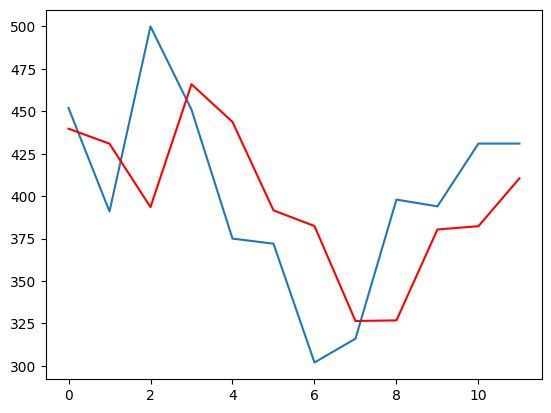

In [64]:
# evaluate the finalized model on the validation dataset

# load and prepare datasets
dataset = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
X = dataset['Robberies'].astype(float).values
history = [x for x in X]
validation = pd.read_csv('validation.csv', index_col=0, parse_dates=True)
y = validation['Robberies'].astype(float).values

# load model
model_fit_loaded = model_fit.load('model.pkl')
lam_loaded = np.load('model_lambda.npy')

# make first prediction
predictions = list()
yhat = model_fit_loaded.forecast()[0]
yhat = boxcox_inverse(yhat, lam_loaded)[0]
predictions.append(yhat)
history.append(y[0])
print(f'>Predicted={yhat:.3f}, Expected={y[0]:.3f}')

# rolling forecasts
for i in range(1, len(y)):
  # transform
  transformed, lam = boxcox(history)
  # transform
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(2, 0, 1))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print(f'>Predicted={yhat:.3f}, Expected={obs:.3f}')

# report performance
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse:.3f}')
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

#### Extensions

There may be more to do to improve the result:
- Statistical Significance Tests: Use a statistical test to check if the diﬀerence in results between diﬀerent models is statistically significant. The Student’s t-test would be a good place to start.
- Grid Search with Data Transforms: Repeat the grid search in the ARIMA hyperpa-rameters with the Box-Cox transform and see if a diﬀerent and better set of parameters can be achieved.
- Inspect Residuals: Investigate the residual forecast errors on the final model with Box-Cox transforms to see if there is a further bias and/or autocorrelation that can be addressed.
- Lean Model Saving: Simplify model saving to only store the required coeﬃcients rather than the entire ARIMAResults object.
- Manullay Handle Trend: Model the trend directly with a linear or nonlinear model and explicitly remove it from the series. This may result in better performance if the trend is nonlinear and can be modeled better than the linear case.
- Confidence Interval: Display the confidence intervals for the predictions on the validation dataset.
- Data Selection: Consider modeling the problem without the first two years of data and see if this has an impact on forecast skill.